In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Data and Creating Index Mappings

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-latest-small/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp


### Splitting Data into Training and Test Sets

In [ ]:
# Define the number of last ratings to use as test data
m = 5  # Use last 5 ratings of each user for testing

# Split the data into training and test sets
train_user_ids, train_movie_ids, train_ratings = [], [], []
test_user_ids, test_movie_ids, test_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    if len(ratings) > m:
        # Training data
        for movie_id, rating, _ in ratings[:-m]:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)
        # Test data
        for movie_id, rating, _ in ratings[-m:]:
            test_user_ids.append(user_idx)
            test_movie_ids.append(movie_to_index[movie_id])
            test_ratings.append(rating)
    else:
        # Use all for training if not enough ratings
        for movie_id, rating, _ in ratings:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)

### Handling Cold Start Items

In [ ]:
# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Check for cold start items in the test set
train_movie_set = set(train_movie_ids)
cold_start_indices = [i for i, movie_id in enumerate(test_movie_ids) if movie_id not in train_movie_set]

# Add cold start items to the training set
if cold_start_indices:
    train_user_ids = np.concatenate((train_user_ids, test_user_ids[cold_start_indices]))
    train_movie_ids = np.concatenate((train_movie_ids, test_movie_ids[cold_start_indices]))
    train_ratings = np.concatenate((train_ratings, test_ratings[cold_start_indices]))

### Re-indexing the Data

In [ ]:
# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Remap test user and movie indices
indexed_test_user_ids = np.array([train_user_to_index.get(uid, -1) for uid in test_user_ids])
indexed_test_movie_ids = np.array([train_movie_to_index.get(mid, -1) for mid in test_movie_ids])

# Filter valid test indices to ensure they are known in the training set
valid_test_indices = (indexed_test_user_ids != -1) & (indexed_test_movie_ids != -1)

test_user_ids = indexed_test_user_ids[valid_test_indices]
test_movie_ids = indexed_test_movie_ids[valid_test_indices]
test_ratings = test_ratings[valid_test_indices]

# Output the shapes of the training and test sets
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)
print("Test data:", test_user_ids.shape, test_movie_ids.shape, test_ratings.shape)

# Report the number of cold start items
total_test_items = len(test_movie_ids)
removed_count = len(cold_start_indices)
print(f"Total test items: {total_test_items}")
print(f"Cold start items added to training set: {removed_count}")
print(f"Percentage of cold start items: {removed_count / total_test_items * 100:.2f}%")

Training data: (97896,) (97896,) (97896,)
Test data: (3050,) (3050,) (3050,)
Total test items: 3050
Cold start items added to training set: 110
Percentage of cold start items: 3.61%


## Build a model that finds Maximum Likelihood Estimate for user + item biases with alternating least squares

In [ ]:
def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    predictions = global_bias + user_bias[user_ids] + item_bias[movie_ids]
    errors = ratings - predictions
    return -0.5 * lambda_reg * np.sum(errors**2) - 0.5 * gamma * (np.sum(user_bias**2) + np.sum(item_bias**2))

def calculate_rmse(predictions, ratings):
    mse = np.mean((predictions - ratings) ** 2)
    return np.sqrt(mse)

def initialize_biases(user_ids, movie_ids, ratings):
    global_mean = np.mean(ratings)
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    return user_bias, item_bias, global_mean

def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    for i, user_id in enumerate(np.unique(user_ids)):
        indices = np.where(user_ids == user_id)[0]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[movie_ids[indices]]
        # Apply the lambda scaling to the error term and include regularization
        user_bias[i] = (np.sum(lambda_reg * (ratings_subset - (global_bias + item_bias_subset))) /
                        (lambda_reg * len(indices) + gamma))
    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    for j, movie_id in enumerate(np.unique(movie_ids)):
        indices = np.where(movie_ids == movie_id)[0]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_ids[indices]]
        # Apply the lambda scaling to the error term and include regularization
        item_bias[j] = (np.sum(lambda_reg * (ratings_subset - (global_bias + user_bias_subset))) /
                        (lambda_reg * len(indices) + gamma))
    return item_bias

def predict_rating(user_id, movie_id, user_bias, item_bias, global_bias):
    return global_bias + user_bias[user_id] + item_bias[movie_id]

def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings, iterations, lambda_reg, gamma_bias):
    user_bias, item_bias, global_mean = initialize_biases(train_user_ids, train_movie_ids, train_ratings)
    train_rmses = []
    test_rmses = []
    train_losses = []
    test_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias)

        # Compute predictions and RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, global_mean)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias)
        train_losses.append(train_loss)

        # Compute predictions and RMSE for test set
        test_predictions = predict_rating(test_user_ids, test_movie_ids, user_bias, item_bias, global_mean)
        test_rmse = calculate_rmse(test_predictions, test_ratings)
        test_rmses.append(test_rmse)
        test_loss = calculate_loss(test_user_ids, test_movie_ids, test_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias)
        test_losses.append(test_loss)

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return user_bias, item_bias, global_mean, train_rmses, test_rmses, train_losses, test_losses


## Hyperparameter tuning on 100k dataset

In [ ]:
from sklearn.model_selection import ParameterGrid

# Number of epochs
epochs = 10

# Hyperparameter grid
param_grid = {
    'lambda_reg': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma_bias': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Grid search initialization
best_params = None
best_rmse = float('inf')

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")

    # Train the model with the current hyperparameters
    user_bias, item_bias, global_mean, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
        indexed_train_user_ids, indexed_train_movie_ids,
        train_ratings, test_user_ids, test_movie_ids, test_ratings,
        epochs, params['lambda_reg'], params['gamma_bias']
    )

    # Evaluate the model based on the last RMSE after the final epoch
    final_rmse = test_rmses[-1]
    print(f"Final RMSE after epoch {epochs}: {final_rmse}")

    # Update the best parameters if the current final RMSE is lower
    if final_rmse < best_rmse:
        best_rmse = final_rmse
        best_params = params

# Print the best hyperparameters and the corresponding RMSE
print(f"Best params: {best_params}")
print(f"Best RMSE: {best_rmse}")

# Final model training with the best parameters
user_bias, item_bias, global_mean, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    indexed_train_user_ids, indexed_train_movie_ids,
    train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, best_params['lambda_reg'], best_params['gamma_bias']
)


Testing params: {'gamma_bias': 0.1, 'lambda_reg': 0.1}
Iteration 1, Train RMSE: 0.8084, Test RMSE: 0.9409, Train Loss: -3321.3076, Test Loss: -257.1369
Iteration 2, Train RMSE: 0.7936, Test RMSE: 0.9215, Train Loss: -3218.1820, Test Loss: -265.2474
Iteration 3, Train RMSE: 0.7924, Test RMSE: 0.9196, Train Loss: -3212.0726, Test Loss: -267.5911
Iteration 4, Train RMSE: 0.7922, Test RMSE: 0.9192, Train Loss: -3210.7340, Test Loss: -267.6086
Iteration 5, Train RMSE: 0.7921, Test RMSE: 0.9191, Train Loss: -3209.8323, Test Loss: -267.1544
Iteration 6, Train RMSE: 0.7921, Test RMSE: 0.9190, Train Loss: -3209.0816, Test Loss: -266.6630
Iteration 7, Train RMSE: 0.7921, Test RMSE: 0.9190, Train Loss: -3208.4410, Test Loss: -266.2217
Iteration 8, Train RMSE: 0.7921, Test RMSE: 0.9190, Train Loss: -3207.8925, Test Loss: -265.8413
Iteration 9, Train RMSE: 0.7920, Test RMSE: 0.9190, Train Loss: -3207.4225, Test Loss: -265.5171
Iteration 10, Train RMSE: 0.7920, Test RMSE: 0.9191, Train Loss: -3207.0

## Best params: {'gamma_bias': 0.3, 'lambda_reg': 0.4}

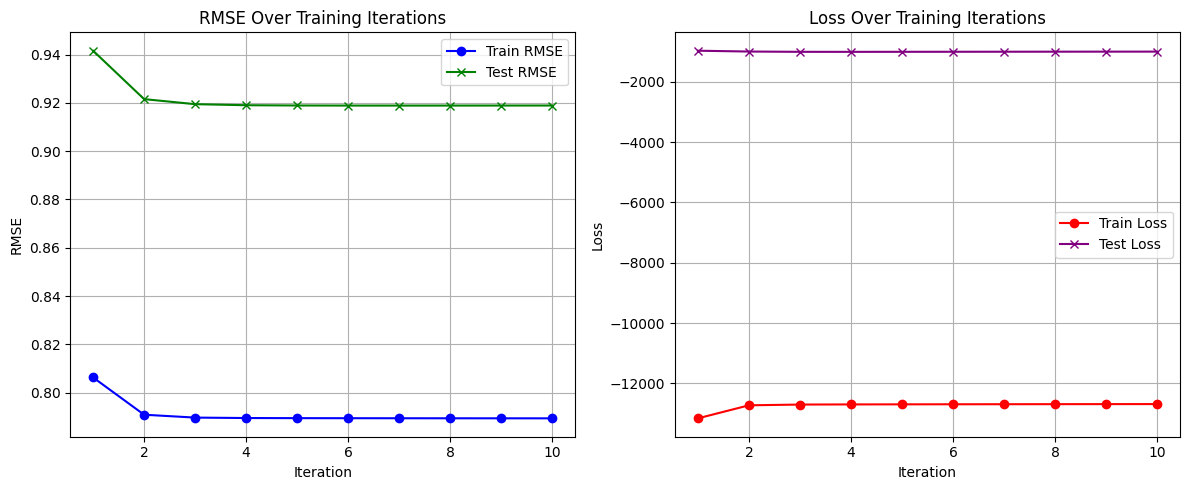

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Set up the figure and the subplots
plt.figure(figsize=(12, 5))  # Adjust figure size to a reasonable dimension for two plots

# Plotting the Train and Test RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.plot(iterations, test_rmses, marker='x', linestyle='-', color='green', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train and Test Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.plot(iterations, test_losses, marker='x', linestyle='-', color='purple', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()

## Training on 25m Movielens dataset

### Loading Data and Creating Index Mappings

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp


### Splitting Data into Training and Test Sets

In [ ]:
# Define the number of last ratings to use as test data
m = 5  # Use last 5 ratings of each user for testing

# Split the data into training and test sets
train_user_ids, train_movie_ids, train_ratings = [], [], []
test_user_ids, test_movie_ids, test_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    if len(ratings) > m:
        # Training data
        for movie_id, rating, _ in ratings[:-m]:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)
        # Test data
        for movie_id, rating, _ in ratings[-m:]:
            test_user_ids.append(user_idx)
            test_movie_ids.append(movie_to_index[movie_id])
            test_ratings.append(rating)
    else:
        # Use all for training if not enough ratings
        for movie_id, rating, _ in ratings:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)

### Handling Cold Start Items

In [ ]:
# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Check for cold start items in the test set
train_movie_set = set(train_movie_ids)
cold_start_indices = [i for i, movie_id in enumerate(test_movie_ids) if movie_id not in train_movie_set]

# Add cold start items to the training set
if cold_start_indices:
    train_user_ids = np.concatenate((train_user_ids, test_user_ids[cold_start_indices]))
    train_movie_ids = np.concatenate((train_movie_ids, test_movie_ids[cold_start_indices]))
    train_ratings = np.concatenate((train_ratings, test_ratings[cold_start_indices]))

### Re-indexing the Data

In [ ]:
# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Remap test user and movie indices
indexed_test_user_ids = np.array([train_user_to_index.get(uid, -1) for uid in test_user_ids])
indexed_test_movie_ids = np.array([train_movie_to_index.get(mid, -1) for mid in test_movie_ids])

# Filter valid test indices to ensure they are known in the training set
valid_test_indices = (indexed_test_user_ids != -1) & (indexed_test_movie_ids != -1)

test_user_ids = indexed_test_user_ids[valid_test_indices]
test_movie_ids = indexed_test_movie_ids[valid_test_indices]
test_ratings = test_ratings[valid_test_indices]

# Output the shapes of the training and test sets
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)
print("Test data:", test_user_ids.shape, test_movie_ids.shape, test_ratings.shape)

# Report the number of cold start items
total_test_items = len(test_movie_ids)
removed_count = len(cold_start_indices)
print(f"Total test items: {total_test_items}")
print(f"Cold start items added to training set: {removed_count}")
print(f"Percentage of cold start items: {removed_count / total_test_items * 100:.2f}%")

Training data: (24187673,) (24187673,) (24187673,)
Test data: (812705,) (812705,) (812705,)
Total test items: 812705
Cold start items added to training set: 283
Percentage of cold start items: 0.03%


## Update ALS code with Batch Processing and GPU computations for training in Google Colab

In [ ]:
import torch

# Calculate loss on GPU
def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    # Ensure all inputs are on GPU and have correct types
    predictions = global_bias + user_bias[user_ids] + item_bias[movie_ids]
    errors = ratings - predictions
    # Ensure the calculations do not overflow or underflow
    loss = -0.5 * lambda_reg * torch.sum(errors ** 2) - 0.5 * gamma * (torch.sum(user_bias ** 2) + torch.sum(item_bias ** 2))
    return loss

# Calculate RMSE on GPU
def calculate_rmse(predictions, ratings):
    mse = torch.mean((predictions - ratings) ** 2)
    return torch.sqrt(mse)

# Initialize biases on GPU
def initialize_biases(user_ids, movie_ids, ratings):
    global_mean = torch.mean(ratings)
    unique_users = torch.unique(user_ids)
    unique_movies = torch.unique(movie_ids)
    user_bias = torch.zeros(len(unique_users), device='cuda', dtype=torch.float32)
    item_bias = torch.zeros(len(unique_movies), device='cuda', dtype=torch.float32)
    return user_bias, item_bias, global_mean

# Update user biases in batches on GPU
def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma, batch_size=100000):
    unique_users = torch.unique(user_ids)

    for i in range(0, len(unique_users), batch_size):
        batch_users = unique_users[i:i+batch_size]
        indices = torch.isin(user_ids, batch_users)
        ratings_subset = ratings[indices]
        movie_ids_subset = movie_ids[indices]
        user_ids_subset = user_ids[indices]
        item_bias_subset = item_bias[movie_ids_subset]

        # Numerically stable update for user_bias
        user_bias[batch_users] = (lambda_reg * torch.bincount(user_ids_subset, weights=(ratings_subset - (global_bias + item_bias_subset)), minlength=len(user_bias))[batch_users] /
                                  (lambda_reg * torch.bincount(user_ids_subset, minlength=len(user_bias))[batch_users] + gamma))

    return user_bias

# Update item biases in batches on GPU
def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma, batch_size=100000):
    unique_movies = torch.unique(movie_ids)

    for i in range(0, len(unique_movies), batch_size):
        batch_movies = unique_movies[i:i+batch_size]
        indices = torch.isin(movie_ids, batch_movies)
        ratings_subset = ratings[indices]
        user_ids_subset = user_ids[indices]
        movie_ids_subset = movie_ids[indices]
        user_bias_subset = user_bias[user_ids_subset]

        # Numerically stable update for item_bias
        item_bias[batch_movies] = (lambda_reg * torch.bincount(movie_ids_subset, weights=(ratings_subset - (global_bias + user_bias_subset)), minlength=len(item_bias))[batch_movies] /
                                   (lambda_reg * torch.bincount(movie_ids_subset, minlength=len(item_bias))[batch_movies] + gamma))

    return item_bias

# Predict rating on GPU
def predict_rating(user_ids, movie_ids, user_bias, item_bias, global_bias):
    return global_bias + user_bias[user_ids] + item_bias[movie_ids]

# Alternating Least Squares with batch processing on GPU
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings, iterations, lambda_reg, gamma_bias, batch_size=100000):
    user_bias, item_bias, global_mean = initialize_biases(train_user_ids, train_movie_ids, train_ratings)
    train_rmses = []
    test_rmses = []
    train_losses = []
    test_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias, batch_size)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias, batch_size)

        # Compute predictions and RMSE for training set in batches
        train_rmse = 0
        train_loss = 0
        for i in range(0, len(train_user_ids), batch_size):
            batch_user_ids = train_user_ids[i:i+batch_size]
            batch_movie_ids = train_movie_ids[i:i+batch_size]
            batch_ratings = train_ratings[i:i+batch_size]

            train_predictions = predict_rating(batch_user_ids, batch_movie_ids, user_bias, item_bias, global_mean)
            train_rmse += calculate_rmse(train_predictions, batch_ratings).item()
            train_loss += calculate_loss(batch_user_ids, batch_movie_ids, batch_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias).item()

        train_rmses.append(train_rmse / (len(train_user_ids) / batch_size))
        train_losses.append(train_loss / (len(train_user_ids) / batch_size))

        # Compute predictions and RMSE for test set in batches
        test_rmse = 0
        test_loss = 0
        for i in range(0, len(test_user_ids), batch_size):
            batch_user_ids = test_user_ids[i:i+batch_size]
            batch_movie_ids = test_movie_ids[i:i+batch_size]
            batch_ratings = test_ratings[i:i+batch_size]

            test_predictions = predict_rating(batch_user_ids, batch_movie_ids, user_bias, item_bias, global_mean)
            test_rmse += calculate_rmse(test_predictions, batch_ratings).item()
            test_loss += calculate_loss(batch_user_ids, batch_movie_ids, batch_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias).item()

        test_rmses.append(test_rmse / (len(test_user_ids) / batch_size))
        test_losses.append(test_loss / (len(test_user_ids) / batch_size))

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmses[-1]:.4f}, Test RMSE: {test_rmses[-1]:.4f}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return user_bias, item_bias, global_mean, train_rmses, test_rmses, train_losses, test_losses



## Training on 25m Dataset

In [ ]:
# Example usage with GPU
# Convert your data to torch tensors and move them to GPU with the correct precision
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device='cuda')
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device='cuda')
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')
test_user_ids = torch.tensor(test_user_ids, dtype=torch.long, device='cuda')
test_movie_ids = torch.tensor(test_movie_ids, dtype=torch.long, device='cuda')
test_ratings = torch.tensor(test_ratings, dtype=torch.float32, device='cuda')

# Number of epochs
epochs = 10

# Hyperparameters
lambda_reg = 0.4
gamma_bias = 0.3
batch_size = 100000

# Example usage of alternating_least_squares
user_bias, item_bias, global_mean, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, lambda_reg, gamma_bias, batch_size
)

Iteration 1, Train RMSE: 0.8647, Test RMSE: 1.0361, Train Loss: -23254.9229, Test Loss: -26681.3112
Iteration 2, Train RMSE: 0.8496, Test RMSE: 1.0185, Train Loss: -22194.8198, Test Loss: -25493.0531
Iteration 3, Train RMSE: 0.8489, Test RMSE: 1.0181, Train Loss: -22260.9613, Test Loss: -25579.0452
Iteration 4, Train RMSE: 0.8488, Test RMSE: 1.0180, Train Loss: -22284.1106, Test Loss: -25604.5989
Iteration 5, Train RMSE: 0.8488, Test RMSE: 1.0180, Train Loss: -22283.9723, Test Loss: -25602.9911
Iteration 6, Train RMSE: 0.8488, Test RMSE: 1.0180, Train Loss: -22278.1365, Test Loss: -25595.5609
Iteration 7, Train RMSE: 0.8488, Test RMSE: 1.0180, Train Loss: -22271.3051, Test Loss: -25587.4755
Iteration 8, Train RMSE: 0.8488, Test RMSE: 1.0179, Train Loss: -22264.4842, Test Loss: -25579.6545
Iteration 9, Train RMSE: 0.8488, Test RMSE: 1.0179, Train Loss: -22257.8262, Test Loss: -25572.1382
Iteration 10, Train RMSE: 0.8488, Test RMSE: 1.0179, Train Loss: -22251.3210, Test Loss: -25564.8482

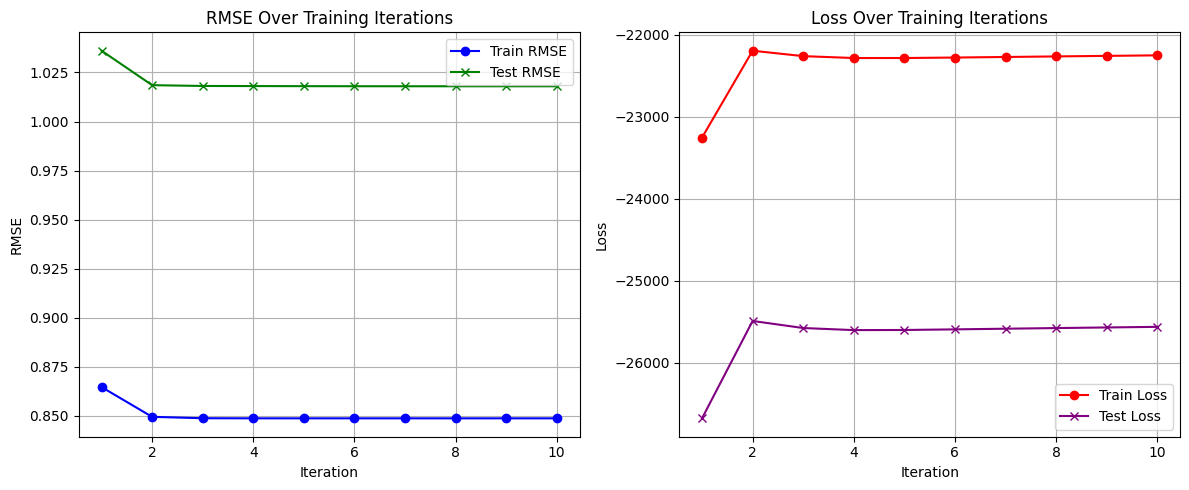

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Set up the figure and the subplots
plt.figure(figsize=(12, 5))  # Adjust figure size to a reasonable dimension for two plots

# Plotting the Train and Test RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.plot(iterations, test_rmses, marker='x', linestyle='-', color='green', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train and Test Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.plot(iterations, test_losses, marker='x', linestyle='-', color='purple', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()

## Final Model Training with Full 25M dataset

### Data preprocessing with only training set

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

# Prepare the training data
train_user_ids, train_movie_ids, train_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    for movie_id, rating, _ in ratings:
        train_user_ids.append(user_idx)
        train_movie_ids.append(movie_to_index[movie_id])
        train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)

# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Output the shapes of the training set
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)

Training data: (25000095,) (25000095,) (25000095,)


## Updated ALS function code

In [ ]:
# Alternating Least Squares with batch processing on GPU
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, iterations, lambda_reg, gamma_bias, batch_size=100000):
    user_bias, item_bias, global_mean = initialize_biases(train_user_ids, train_movie_ids, train_ratings)
    train_rmses = []
    train_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias, batch_size)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias, batch_size)

        # Compute predictions and RMSE for training set in batches
        train_rmse = 0
        train_loss = 0
        for i in range(0, len(train_user_ids), batch_size):
            batch_user_ids = train_user_ids[i:i+batch_size]
            batch_movie_ids = train_movie_ids[i:i+batch_size]
            batch_ratings = train_ratings[i:i+batch_size]

            train_predictions = predict_rating(batch_user_ids, batch_movie_ids, user_bias, item_bias, global_mean)
            train_rmse += calculate_rmse(train_predictions, batch_ratings).item()
            train_loss += calculate_loss(batch_user_ids, batch_movie_ids, batch_ratings, user_bias, item_bias, global_mean, lambda_reg, gamma_bias).item()

        train_rmses.append(train_rmse / (len(train_user_ids) / batch_size))
        train_losses.append(train_loss / (len(train_user_ids) / batch_size))

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmses[-1]:.4f}, Train Loss: {train_losses[-1]:.4f}")

    return user_bias, item_bias, global_mean, train_rmses, train_losses

## Use full 25M dataset to train the model

In [ ]:
# Example usage with GPU
# Convert your data to torch tensors and move them to GPU with the correct precision
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device='cuda')
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device='cuda')
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')

# Number of epochs
epochs = 10

# Hyperparameters
lambda_reg = 0.4
gamma_bias = 0.3
batch_size = 100000

# Train the model using the updated alternating_least_squares function
user_bias, item_bias, global_mean, train_rmses, train_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings,
    epochs, lambda_reg, gamma_bias, batch_size
)

Iteration 1, Train RMSE: 0.8698, Train Loss: -23174.9546
Iteration 2, Train RMSE: 0.8546, Train Loss: -22181.0029
Iteration 3, Train RMSE: 0.8538, Train Loss: -22255.8748
Iteration 4, Train RMSE: 0.8538, Train Loss: -22281.1319
Iteration 5, Train RMSE: 0.8538, Train Loss: -22281.5101
Iteration 6, Train RMSE: 0.8538, Train Loss: -22275.7326
Iteration 7, Train RMSE: 0.8538, Train Loss: -22268.8197
Iteration 8, Train RMSE: 0.8538, Train Loss: -22261.8775
Iteration 9, Train RMSE: 0.8538, Train Loss: -22255.0842
Iteration 10, Train RMSE: 0.8538, Train Loss: -22248.4403


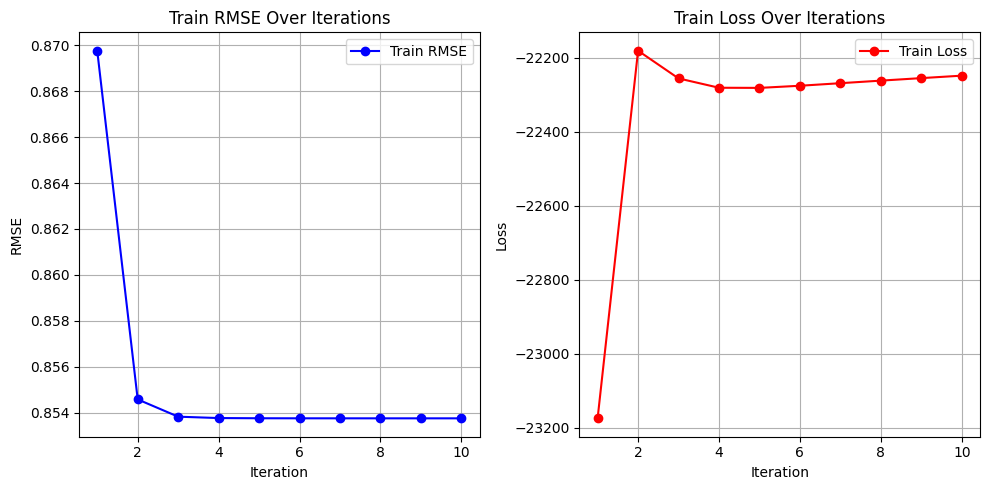

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Set up the figure and the subplots
plt.figure(figsize=(10, 5))

# Plotting the Train RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train RMSE Over Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss Over Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()
